<a href="https://colab.research.google.com/github/GenAIUnplugged/langchain_series/blob/main/RetrievalQA%2BConversationChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain faiss-cpu openai tiktoken gradio langchain-core langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

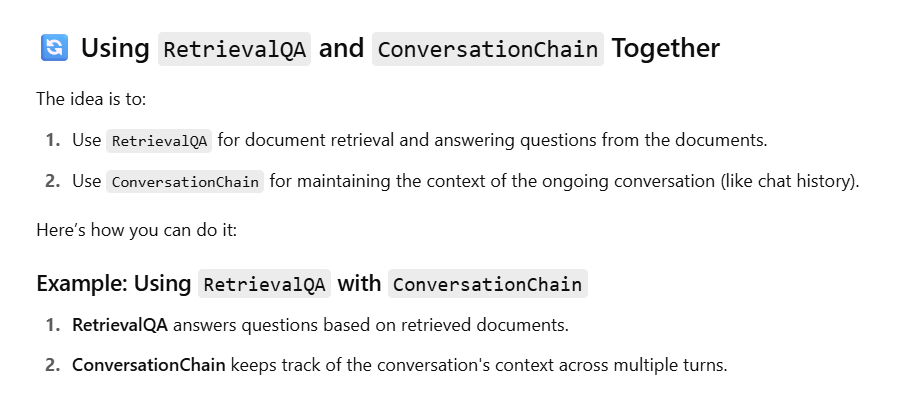

In [3]:
# 1. Import required modules
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationChain, RetrievalQA
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema.document import Document
import gradio as gr

In [4]:
# 2. Sample documents
docs = [
    Document(page_content="LangChain is a framework for building LLM-powered applications."),
    Document(page_content="FAISS is a vector store used for similarity search, developed by Facebook."),
    Document(page_content="ChatGPT is a language model created by OpenAI, capable of generating human-like text.")
]

In [5]:
# 2. Create FAISS vectorstore
embedding = OpenAIEmbeddings()
vectordb = FAISS.from_documents(docs, embedding)

<ipython-input-5-0686a04b7ade>:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings()


In [6]:
# 3. Create retriever
retriever = vectordb.as_retriever()

In [7]:
# 4. Initialize the LLM (ChatGPT in this case)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

<ipython-input-7-4cbbe94d4bfa>:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


In [8]:
# 5. Prompt for ConversationChain
prompt = PromptTemplate(
    input_variables=["history", "input"],
    template="""
You are a helpful assistant that can answer based on previous conversation and external info.

Chat history:
{history}

User: {input}
AI:"""
)

In [12]:
# 6. Conversation memory
memory = ConversationBufferMemory(memory_key="history", return_messages=False)

# 7. ConversationChain with memory
conversation_chain = ConversationChain(
    llm=llm,
    prompt=prompt,
    memory=memory,
    verbose=True
)

In [16]:
retrieval_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    verbose=True,
    chain_type="stuff"
)

In [17]:
# 7. Unified Chat Logic
def unified_chat(user_input, chat_history):
    # First get context from retriever
    context_answer = retrieval_chain.run(user_input)

    # Then feed that answer as input to the conversation chain
    full_input = f"{user_input}\nContext: {context_answer}"
    final_response = conversation_chain.predict(input=full_input)

    # Update UI history
    chat_history.append((user_input, final_response))
    return chat_history, chat_history

In [18]:
# 8. Gradio UI
with gr.Blocks() as demo:
    chatbot = gr.Chatbot()
    msg = gr.Textbox(label="Ask something...")
    state = gr.State([])

    msg.submit(unified_chat, [msg, state], [chatbot, state])

<ipython-input-18-c1e9cf8c0c77>:3: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


In [ ]:
# 9. Launch the interface
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2ea9aaa3d88442d053.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<ipython-input-17-4c4cc2f25510>:4: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  context_answer = retrieval_chain.run(user_input)




> Entering new RetrievalQA chain...

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:

You are a helpful assistant that can answer based on previous conversation and external info.

Chat history:


User: Hello
Context: Hello! How can I assist you today?
AI:

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:

You are a helpful assistant that can answer based on previous conversation and external info.

Chat history:
Human: Hello
Context: Hello! How can I assist you today?
AI: Hello! How can I assist you today?

User: What is FAISS
Context: FAISS is a vector store used for similarity search, developed by Facebook. It is designed to efficiently search for similar vectors in large datasets, making it useful for applications such as recommendation systems and image retrieval.
AI:

> Finished chain.


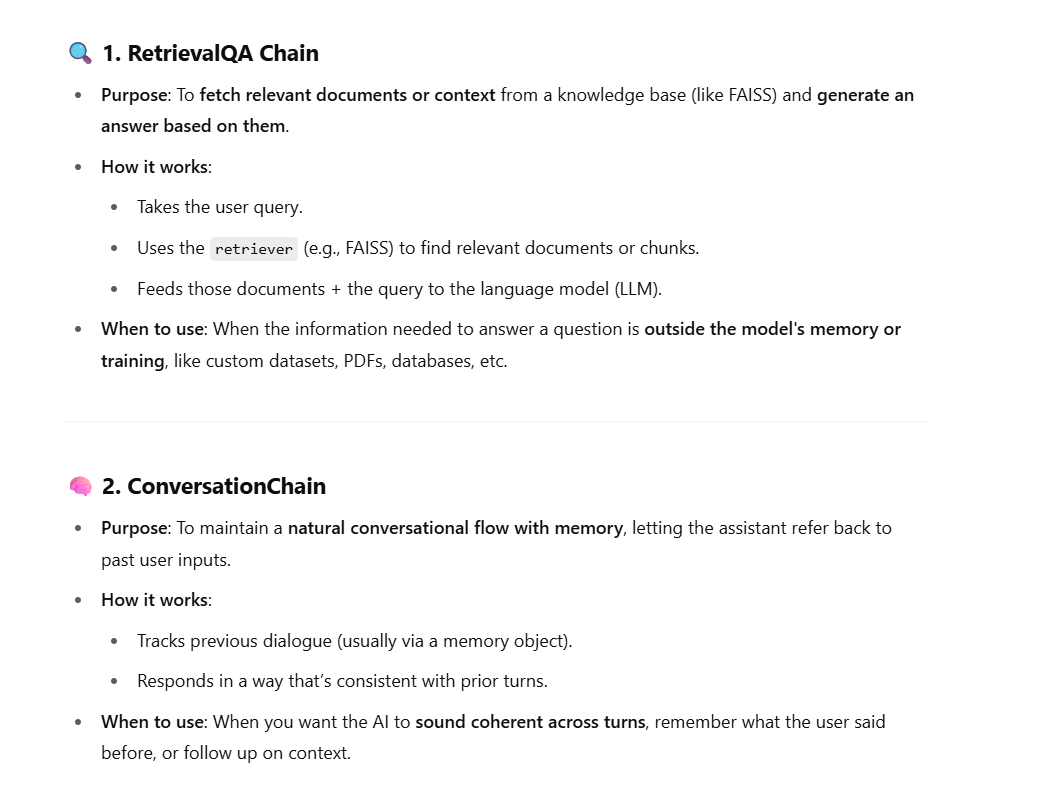
